In [1]:
import json
from pathlib import Path
from mt.helper import flatten
from datetime import datetime
from dateutil.parser import parse
from typing import Any
import networkx as nx
from torch_geometric.data import Data, Batch
import requests
import re
import torch
from torch.utils.data import Dataset
from torch_geometric.loader import DataLoader
import pickle
import concurrent.futures
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx
import numpy as np

/home/fox/projects/general/learning-portfolio/university/masters/masters-thesis/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if (path:=Path("type_to_int.json")).exists():
    with open(path) as f:
        type_to_int = json.load(f)
else:
    response = requests.get("https://raw.githubusercontent.com/tree-sitter/tree-sitter-python/master/src/node-types.json")
    types = re.findall(r'"type": "(.+)"', response.text)
    type_to_int =  {"UNK": 0} | {t: i+1 for i, t in enumerate(list(set(types)))}
    with open("type_to_int.json", "w") as f:
        json.dump(type_to_int, f)

In [3]:
repo = Path("/home/fox/projects/general/learning-portfolio/university/masters/masters-thesis/data/repos/pytorch/vision")
repo

PosixPath('/home/fox/projects/general/learning-portfolio/university/masters/masters-thesis/data/repos/pytorch/vision')

In [4]:
commit_data_dir = repo / "commit_data"
commit_paths = list(commit_data_dir.glob("*.json"))
commit_paths.sort(key = lambda path: int(path.name.split("_")[0]))
commit_paths = {path.name.split("_")[1].removesuffix(".json"): path for path in commit_paths}

In [5]:
pt_dir = repo / "pts"
pt_dir.mkdir(exist_ok=True)

In [6]:
class GraphDataset(Dataset):
    def __init__(self, root_dir: Path) -> None:
        self.root_dir = root_dir
        self.files = list(root_dir.glob("*.pt"))
        self.num_samples = len(self.files)

        self.tgt_mean, self.tgt_std = self.compute_mean_std()

    def __len__(self) -> int:
        return self.num_samples

    def __getitem__(self, idx: int) -> tuple[str, Batch, torch.FloatTensor]:
        commit_sha, batch, target = torch.load(self.root_dir / f"batch_{idx}.pt")
        target_standardized = (target - self.tgt_mean) / self.tgt_std
        return commit_sha, batch, target_standardized
    
    def compute_mean_std(self) -> tuple[float, float]:
        tot_sum, tot_sum_sq, cnt = 0, 0, 0

        for file in self.files:
            _, _, target = torch.load(file)
            tot_sum += target
            tot_sum_sq += (target ** 2)
            cnt += 1
        
        mean = tot_sum / cnt
        var = (tot_sum_sq / cnt) - (mean ** 2)
        std = math.sqrt(var)

        return mean, std

    def inverse_standardize(self, target_standardized: float) -> float:
        return target_standardized * self.tgt_std + self.tgt_mean

In [7]:
# Instantiate the dataset
dataset = GraphDataset(root_dir=pt_dir)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [8]:
import torch
from torch_geometric.data import Data, Batch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool

class NodeFeatureEmbedding(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(NodeFeatureEmbedding, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        
    def forward(self, x):
        # Assuming x is of shape (num_nodes, 1) where each entry is the category index
        return self.embedding(x.squeeze())  # Embedding lookup and squeeze to drop extra dimension

class TransformerGATModel(nn.Module):
    def __init__(self, embedding_dim, hidden_channels, out_channels, num_heads=2):
        super(TransformerGATModel, self).__init__()
        self.conv1 = GATConv(embedding_dim, hidden_channels, heads=num_heads, concat=True)
        self.conv2 = GATConv(hidden_channels * num_heads, hidden_channels, heads=1, concat=True)
        
        self.attention_fc = torch.nn.Linear(hidden_channels, 1)
        self.regressor = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)
        
        attention_scores = self.attention_fc(x).squeeze(-1)
        attention_weights = F.softmax(attention_scores, dim=0)
        
        x = torch.sum(x * attention_weights.unsqueeze(-1), dim=0)

        return self.regressor(x)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [10]:
embedding_dim = 64
num_node_features = len(type_to_int)

embedding_module = NodeFeatureEmbedding(num_embeddings=num_node_features, embedding_dim=embedding_dim)
model = TransformerGATModel(embedding_dim=embedding_dim, hidden_channels=8, out_channels=1)
model.to(device)
embedding_module.to(device)

NodeFeatureEmbedding(
  (embedding): Embedding(216, 64)
)

In [11]:
best_loss = float('inf')  # Initialize best_loss to infinity
best_model_state = None   # To store the state of the best model
optimizer = torch.optim.Adam(list(embedding_module.parameters()) + list(model.parameters()), lr=0.01)
criterion = nn.MSELoss()

for train_loop in range(5):
    print(f"{datetime.now()}: Training loop {train_loop + 1}")
    for param_group in optimizer.param_groups:
        param_group["lr"] *= 0.1
    weight_path = Path("best_weights_v1.pth")

    if weight_path.exists():
        weights = torch.load(weight_path)
        emb_weights, model_weights = (
            weights["embedding_module_state_dict"],
            weights["model_state_dict"],
        )
        embedding_module.load_state_dict(emb_weights)
        model.load_state_dict(model_weights)

    model.train()
    embedding_module.train()

    for epoch in range(20):  # For example, 10 epochs
        total_loss = 0
        for commit_sha, graph_batch, target in dataloader:
            # Transfer data to the device
            x = graph_batch.x.to(device)
            edge_index = graph_batch.edge_index.to(device)
            batch = graph_batch.batch.to(device)
            target = target.to(device)
            
            optimizer.zero_grad()
            
            # Embedding step
            embedded_x = embedding_module(x)
            
            # Model prediction
            prediction = model(embedded_x, edge_index, batch)
            loss = criterion(prediction, target)
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        epoch_loss = total_loss / len(dataloader)
        print(f'{datetime.now()}: Epoch {epoch+1}: Loss = {epoch_loss}')
        
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            # Save the model state
            best_model_state = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'embedding_module_state_dict': embedding_module.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_loss,
            }
            # Example saving to file, adjust the path as necessary
            torch.save(best_model_state, weight_path)

    print(f'{datetime.now()}: Best Loss: {best_loss}')

2024-05-12 13:01:46.877669: Training loop 1
2024-05-12 13:03:36.479191: Epoch 1: Loss = 0.8984134567676723
2024-05-12 13:05:29.758199: Epoch 2: Loss = 0.779856445835437
2024-05-12 13:07:22.279372: Epoch 3: Loss = 0.7341208935639859
2024-05-12 13:09:15.193099: Epoch 4: Loss = 0.6631056178060067
2024-05-12 13:11:07.087583: Epoch 5: Loss = 0.541492656876846
2024-05-12 13:12:59.492737: Epoch 6: Loss = 0.38870552942234515
2024-05-12 13:14:51.403871: Epoch 7: Loss = 0.44233528390326304
2024-05-12 13:16:44.245071: Epoch 8: Loss = 0.33361462772342454
2024-05-12 13:18:34.741685: Epoch 9: Loss = 0.3279193483239216
2024-05-12 13:20:26.184762: Epoch 10: Loss = 0.3547633028750391
2024-05-12 13:22:18.638615: Epoch 11: Loss = 0.30915100436006226
2024-05-12 13:24:11.152797: Epoch 12: Loss = 0.34957348990936266
2024-05-12 13:26:03.555324: Epoch 13: Loss = 0.32166366322114615
2024-05-12 13:27:55.360136: Epoch 14: Loss = 0.3300653309194546
2024-05-12 13:29:46.425831: Epoch 15: Loss = 0.375644266850363
20

KeyboardInterrupt: 

In [12]:
weights = torch.load(weight_path)
emb_weights, model_weights = (
    weights["embedding_module_state_dict"],
    weights["model_state_dict"],
)
embedding_module.load_state_dict(emb_weights)
model.load_state_dict(model_weights)

<All keys matched successfully>

In [13]:
model.to(device)
embedding_module.to(device)

model.eval()
embedding_module.eval()

NodeFeatureEmbedding(
  (embedding): Embedding(216, 64)
)

In [14]:
targets = []
predictions = []

for commit_sha, graph_batch, target in dataloader:
    # Transfer data to the device
    x = graph_batch.x.to(device)
    edge_index = graph_batch.edge_index.to(device)
    batch = graph_batch.batch.to(device)
    target = target.to(device)
    
    # Embedding step
    embedded_x = embedding_module(x)
    
    # Model prediction
    prediction = model(embedded_x, edge_index, batch)
    targets.append(target.detach().cpu())
    predictions.append(prediction.detach().cpu())

predictions = torch.cat(predictions).numpy()
targets = torch.cat(targets).numpy()

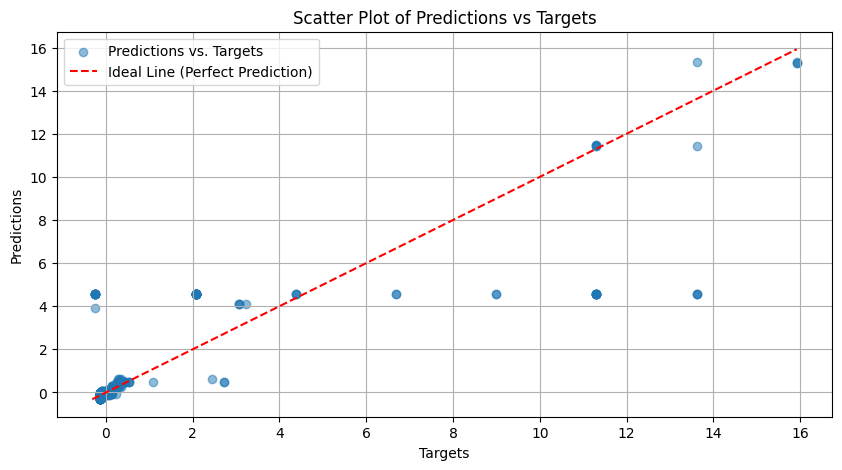

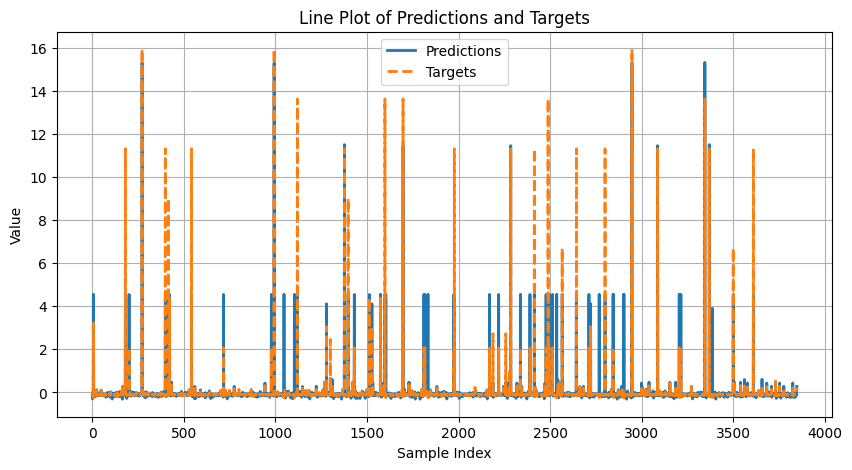

In [15]:
# Scatter plot of predictions vs. targets
plt.figure(figsize=(10, 5))
plt.scatter(targets, predictions, alpha=0.5, label='Predictions vs. Targets')
plt.title('Scatter Plot of Predictions vs Targets')

# Ideal line (x = y line)
ideal_line_range = np.linspace(min(targets.min(), predictions.min()), 
                               max(targets.max(), predictions.max()), 
                               num=100)
plt.plot(ideal_line_range, ideal_line_range, 'r--', label='Ideal Line (Perfect Prediction)')

plt.xlabel('Targets')
plt.ylabel('Predictions')
plt.legend()
plt.grid(True)
plt.show()

# Line plot of predictions and targets
plt.figure(figsize=(10, 5))
plt.plot(predictions, label='Predictions', linewidth=2)
plt.plot(targets, label='Targets', linewidth=2, linestyle='--')
plt.title('Line Plot of Predictions and Targets')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()